<a href="https://colab.research.google.com/github/theclosedbook/ML/blob/main/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("./CMP_facade_DB_base.zip", "r") as zip_ref:
    for member in zip_ref.namelist():
        if member.endswith('.jpg'):
            # extract JPG images to a folder named "jpg_images"
            zip_ref.extract(member, "jpg_images")
        elif member.endswith('.png'):
            # extract PNG images to a folder named "png_images"
            zip_ref.extract(member, "png_images")

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from segmentation_models import get_preprocessing, Unet
from segmentation_models.metrics import iou_score
from segmentation_models.losses import bce_jaccard_loss
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 5.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
# loading image data...
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset


In [ ]:
image_dataset = data_loader('/content/drive/MyDrive/Colab Notebooks/jpg_images/base') #real image 

In [ ]:
mask_dataset = data_loader("/content/drive/MyDrive/Colab Notebooks/png_images/base") #masked image 

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
mask_dataset.shape

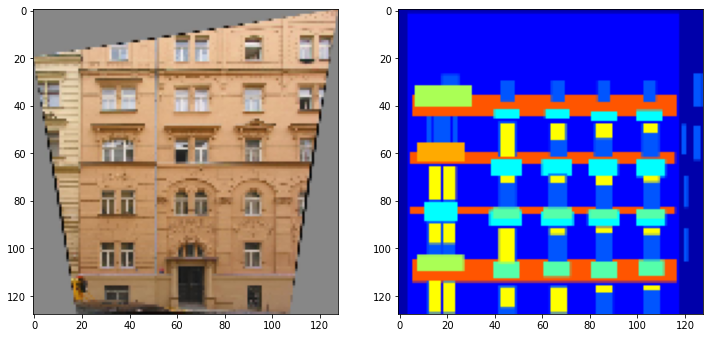

In [ ]:
#sanity check
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [ ]:
mask_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/label_names.csv')

In [ ]:
mask_labels

,name,r,g,b
0,background,0,0,170
1,facade,0,0,255
2,window,0,85,255
3,door,0,170,255
4,cornice,0,255,255
5,sill,85,255,255
6,balcony,170,0,0
7,blind,170,255,85
8,deco,255,85,0
9,molidng,255,170,0


In [ ]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) # adding channel dim...

Unique labels in label dataset are:  [ 0  1  2  3  4  6  7  8  9 10 11]


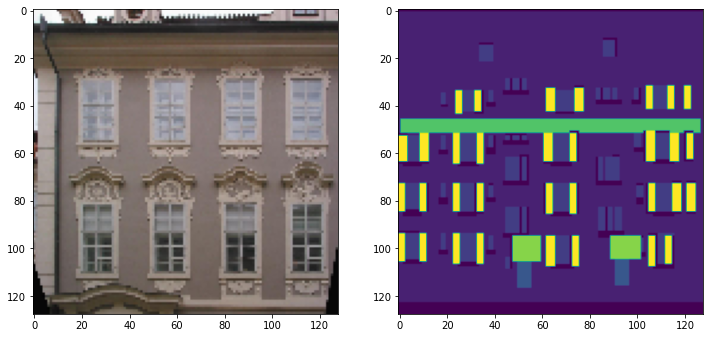

In [ ]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [ ]:
reduced_labels = labels % 11
labels_cat = to_categorical(reduced_labels, num_classes=11)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42 )# train test split

In [ ]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)


In [ ]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)


In [ ]:
# define model...
num_classes = 11
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=num_classes, activation='softmax')


85521592/85521592 [==============================] - 1s 0us/step


In [ ]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


In [ ]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [ ]:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
19/19 [==============================] - 180s 8s/step - loss: 2.1256 - accuracy: 0.2605 - val_loss: 21.4298 - val_accuracy: 0.3911
Epoch 2/100
19/19 [==============================] - 146s 8s/step - loss: 1.7371 - accuracy: 0.3996 - val_loss: 246.1026 - val_accuracy: 0.3983
Epoch 3/100
19/19 [==============================] - 150s 8s/step - loss: 1.6638 - accuracy: 0.4063 - val_loss: 28.0830 - val_accuracy: 0.3902
Epoch 4/100
19/19 [==============================] - 148s 8s/step - loss: 1.6341 - accuracy: 0.4074 - val_loss: 127.9232 - val_accuracy: 0.3825
Epoch 5/100
19/19 [==============================] - 146s 8s/step - loss: 1.6195 - accuracy: 0.4124 - val_loss: 1.9565 - val_accuracy: 0.3416
Epoch 6/100
19/19 [==============================] - 149s 8s/step - loss: 1.6070 - accuracy: 0.4145 - val_loss: 2.0433 - val_accuracy: 0.3683
Epoch 7/100
19/19 [==============================] - 149s 8s/step - loss: 1.6122 - accuracy: 0.4079 - val_loss: 2.2915 - val_accuracy: 0.3269


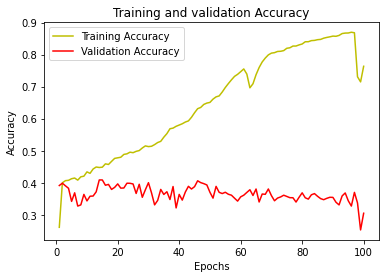

In [ ]:
# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
from keras.models import load_model

model.save('unet.h5')


In [ ]:
from keras.models import load_model

model = load_model('unet.h5')

